In [140]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np

import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt

%matplotlib inline

from controllers import DeePC, DDeePC
plt.rcParams["figure.figsize"] = (15,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')

In [142]:
n = 3 # n = number of states
m = 3 # m = number of inputs
p = 3 # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    
noise_std = 2                      

In [143]:
yd += np.random.rand(T,p)*noise_std
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([100,100,100]))
u_constraonts = np.kron(np.ones(Tf), np.array([100,100,100]))

## Imitation Learning

In [144]:
q = torch.ones(3)*1.8
r = torch.ones(3)*0.018
lam_y = torch.Tensor([0.1])

expert = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraonts,
    stochastic=True, linear=True, q=q, r=r, lam_y=lam_y
)

learner = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=1,
    y_constraints=y_constraints, u_constraints=u_constraonts,
    stochastic=True, linear=True, q=q, r=r
)

learner.lam_y.item()

99.90416717529297

### Before Learning

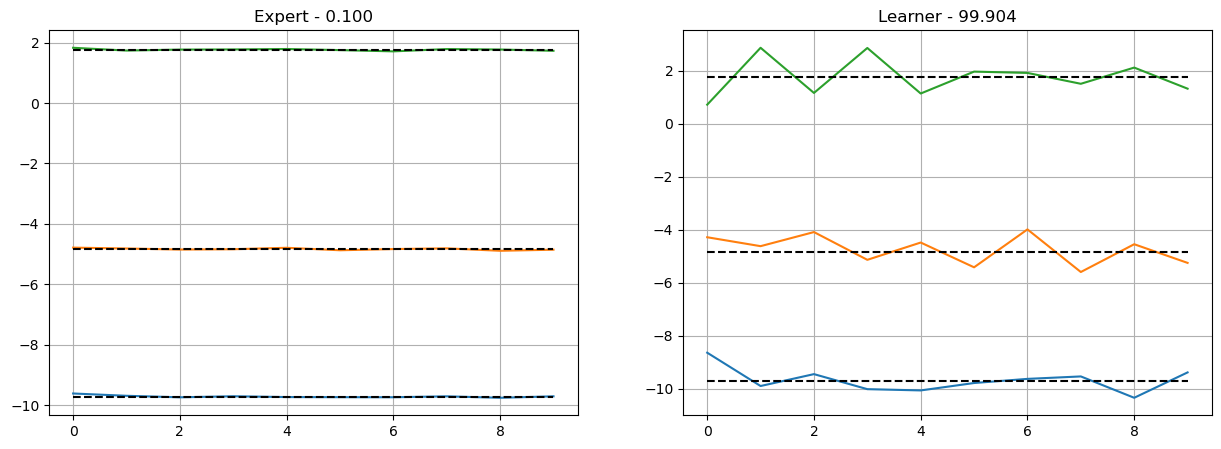

In [145]:
test_ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
test_ref = torch.kron(torch.ones(Tf), test_ref)
# ref_noise = ref + torch.Tensor(np.random.randn(30,)*noise_std)
index = int(np.random.uniform(low=0, high=50))
u_ini, y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
noise = np.random.randn(Tini*p,)*noise_std
y_ini += noise

_, y_pred , _ = learner(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))
_, y, _ = expert(ref=test_ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))

y_pred = y_pred.detach().numpy().reshape((Tf, 3))
y = y.detach().numpy().reshape((Tf, 3))
ref = test_ref.detach().numpy().reshape((Tf, 3))
plt.subplot(1,2,1)
plt.title(f'Expert - {expert.lam_y.item():.3f}')
plt.grid('on')
plt.plot(range(Tf), y)
plt.plot(range(Tf), ref, 'k--')
plt.subplot(1,2,2)
plt.title(f'Learner - {learner.lam_y.item():.3f}')
plt.grid('on')
plt.plot(range(Tf), y_pred)
plt.plot(range(Tf), ref, 'k--')
plt.show()

In [146]:
noise

array([-4.691767  , -1.5678311 ,  2.74382622,  3.58862624,  0.14411541,
       -2.77122246, -3.34336776, -0.9169254 ,  2.57862393, -1.03093526,
        2.40944496, -0.48448555])

In [147]:
optim = torch.optim.Adagrad(learner.parameters(), lr=10)
pbar = tqdm(range(500), ncols=120)
criterion = torch.nn.MSELoss()
scheduler = lr_scheduler.LinearLR(optim, start_factor=1.0, end_factor=0.001, total_iters=20)

for i, count in enumerate(pbar):
    
    # Get random step response
    ref = torch.Tensor(np.random.uniform(size=(3,), low=-10.0, high=10.0))
    ref = torch.kron(torch.ones(Tf), ref)
    
    # Get random initial condition from data
    index = int(np.random.uniform(low=0, high=50))
    u_ini, y_ini = ud[index:Tini + index, :].reshape((Tini*m,)), yd[index:Tini + index].reshape((Tini*p,))
    y_ini += np.random.randn(Tini*p,)*noise_std

    # Get optimal action from controller, take MSE of predicted trajectory and reference signal
    u_pred, y_pred , cost = learner(ref=ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))
    u, y, _ = expert(ref=ref, u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))

    clipped = learner.lam_y.data.item()
    loss = criterion(input=u_pred, target=u)
    optim.zero_grad()
    loss.backward()
    optim.step()

    if count%20 == 0:     
        scheduler.step()
    
    pbar.set_description(f'Loss = {loss.item():.7f}, lam_y = {learner.lam_y.item():.4f}, clipped = {clipped:.4f}, lr = {optim.param_groups[0]["lr"]:.2f}')

Loss = 0.0000000, lam_y = 0.1000, clipped = 0.1000, lr = 0.01: 100%|██████████████████| 500/500 [00:23<00:00, 20.96it/s]


## After Training

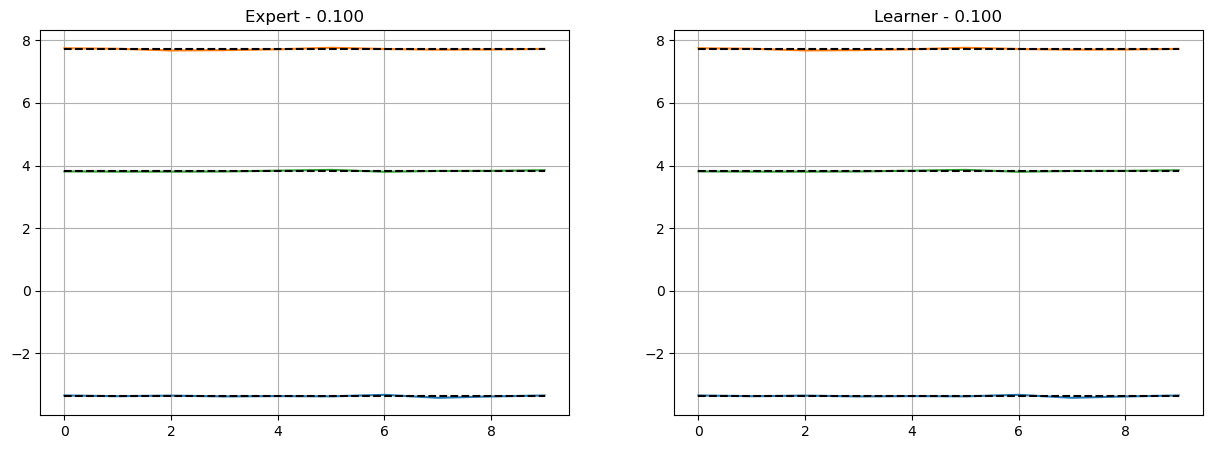

In [148]:
y_pred = y_pred.detach().numpy().reshape((Tf, 3))
y = y.detach().numpy().reshape((Tf, 3))
ref = ref.detach().numpy().reshape((Tf, 3))
plt.subplot(1,2,1)
plt.title(f'Expert - {expert.lam_y.item():.3f}')
plt.grid('on')
plt.plot(range(Tf), y)
plt.plot(range(Tf), ref, 'k--')
plt.subplot(1,2,2)
plt.title(f'Learner - {learner.lam_y.item():.3f}')
plt.grid('on')
plt.plot(range(Tf), y_pred)
plt.plot(range(Tf), ref, 'k--')
plt.show()